In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re

Train Accuracy: 97.4
Train Precision: 99.2
Train Recall: 95.6
Test Accuracy: 94.7
Test Precision: 95.3
Test Recall: 93.8


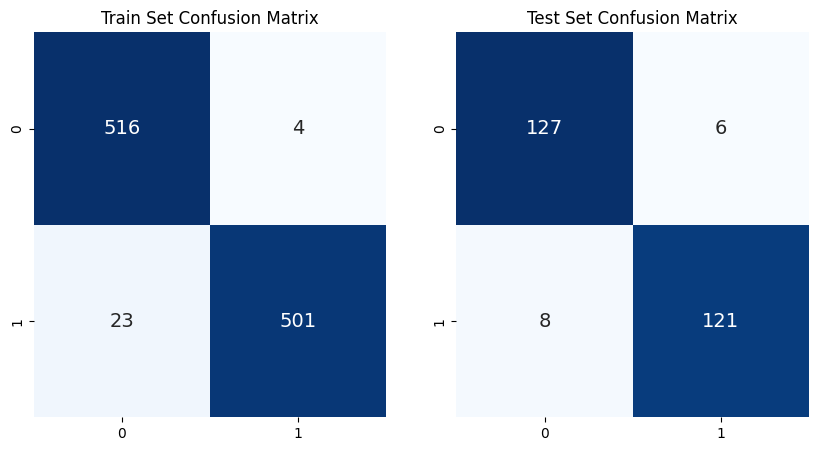

In [6]:
# Init DecisionTree
with open('models/clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
# Load Training and Test data
with open('data/Train-Test-Data.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_train = data[0]
X_test = data[1]
Y_train = data[2]
Y_test = data[3]
    
clf.fit(X_train, Y_train)

# Generate confusion matrix for train set
train_pred = clf.predict(X_train)
train_cm = confusion_matrix(Y_train, train_pred)

# Generate confusion matrix for test set
test_pred = clf.predict(X_test)
test_cm = confusion_matrix(Y_test, test_pred)

# Calculate accuracy, precision, and recall for train set
train_acc = accuracy_score(Y_train, train_pred)
train_prec = precision_score(Y_train, train_pred)
train_rec = recall_score(Y_train, train_pred)

# Calculate accuracy, precision, and recall for test set
test_acc = accuracy_score(Y_test, test_pred)
test_prec = precision_score(Y_test, test_pred)
test_rec = recall_score(Y_test, test_pred)

# Plot the confusion matrices with labels
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], annot_kws={'size': 14}, cbar=False)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax[1], annot_kws={'size': 14}, cbar=False)
ax[0].set_title('Train Set Confusion Matrix')
ax[1].set_title('Test Set Confusion Matrix')

# Print accuracy, precision, and recall
print('Train Accuracy:', round(train_acc*100, 1))
print('Train Precision:', round(train_prec*100, 1))
print('Train Recall:', round(train_rec*100, 1))
print('Test Accuracy:', round(test_acc*100, 1))
print('Test Precision:', round(test_prec*100, 1))
print('Test Recall:', round(test_rec*100, 1))

plt.show()

In [7]:
# Identify which classes are most often misclassified
class_names = ['ham', 'spam']
print('Misclassifications:')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            misclassified = np.where((Y_test == i) & (test_pred == j))[0]
            print(f'{len(misclassified)} {class_names[i]} messages classified as {class_names[j]}')

Misclassifications:
6 ham messages classified as spam
8 spam messages classified as ham


In [25]:
# Analyse a set of test messages
df = pd.read_csv('test_messages.csv', sep='\t', header=None, names=['label', 'message'])

messages = df['message'].to_list()
labels = df['label'].to_list()
    
# Feature engineering
df['message_length'] = df['message'].apply(len)
df['num_digits'] = df['message'].apply(lambda x: sum([1 if char.isdigit() else 0 for char in x]))
df['num_unique_words'] = df['message'].apply(lambda x: len(set(re.findall(r'\w+', x))))
df['stemmed_message'] = df['message'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
    
with open('models/vec.pkl', 'rb') as f:
    tfidf = pickle.load(f)    
    
tfidf_result = tfidf.transform(df['stemmed_message']).toarray()
tfidf_feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf_feature_names)

df.drop(['message', 'stemmed_message', 'label'], axis=1, inplace=True)
df = pd.concat([df, tfidf_df], axis=1)

features = df.to_numpy()

In [54]:
classes = clf.predict(features)
probabilities = clf.predict_proba(features)

for i, message in enumerate(messages):
    
    print('Message: ' + message)
    print('True Label: ' + labels[i])
    
    predicted_label = 'ham'
    if predictions[i] == 1:
        predicted_label = 'spam'
        
    print('Predicted Label: ' + predicted_label)
    print('Probability: ' + str(probabilities[i].max()*100) + '\n')

Message: Congratulations! You've been selected as the lucky winner of a luxury vacation package worth $10,000! Call now to claim your prize at 1-800-555-1234.
True Label: spam
Predicted Label: spam
Probability: 100.0

Message: Hey, just wanted to remind you about our lunch plans tomorrow. We're meeting at that new burger joint downtown at 12:30. See you there!
True Label: ham
Predicted Label: spam
Probability: 100.0

Message: Urgent Notice: Your bank account has been compromised. Please click the following link and enter your personal information to secure your account: www.fakesite.com.
True Label: spam
Predicted Label: ham
Probability: 96.45669291338582

Message: Hi there! How was your weekend? I heard you went hiking. I'd love to see some pictures. Let's catch up soon!
True Label: ham
Predicted Label: ham
Probability: 96.45669291338582

Message: Limited-time offer! Get a free iPhone X with a 2-year contract. Visit our store or call 1-800-123-4567 to claim your free device now!
True 